# Turbofan Engine Degradation  
**Udacity's Machine Learning Engineer Nanodegree - Capstone project**  
Fernando Martinelli Ramacciotti (fernandoramacciotti@gmail.com)

The objective of this work is to predict the Remaining Useful Life (RUL) of turbofan engines. The dataset was downloaded from [NASA's website](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) and it is described as follows:

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine, i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. 
Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. 
The columns correspond to:

* unit number;
* time, in cycles;
* operational settings (3 columns);
* sensor measurements (21 columns).

We have four different files:

* **FD001**: 100 train samples and 100 test samples, one operational condition and one fault mode;
* **FD002**: 260 train samples and 259 test samples, six operational conditions and one fault mode;
* **FD003**: 100 train samples and 100 test samples, one operational condition and two fault modes;
* **FD004**: 248 train samples and 249 test samples, six operational conditions and one fault modes;

In [454]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

plt.style.use('seaborn-whitegrid')

## Data Import

The data for engine in training is for engines up to failure, whereas in test data it is cut to some point before a failure and the corresponding RUL is given in the RUL file. Therefore, let's build a `rul` column in each training and test datasets.

For training, the last observation of each engine is assumed to have `RUL=0` and we, thus, populate the previous samples accordingly. As for test set, the last observation of each is the RUL provided in the RUL file and we populate the previous samples accordingly.

In [455]:
def add_rul_train(df):
    df['rul'] = np.zeros(df.shape[0])
    for u in df.unit_number.unique():
        mask = df.unit_number == u
        sub_time = df.loc[mask, 'time']
        max_cycles = np.max(sub_time)
        df.loc[mask, 'rul'] = max_cycles - sub_time
        
    return df

In [456]:
def add_rul_test(df, rul):
    df['rul'] = np.zeros(df.shape[0])
    for u in df.unit_number.unique():
        mask = df.unit_number == u
        sub_time = df.loc[mask, 'time']
        max_cycles = np.max(sub_time) + rul.loc[u-1, 'rul']
        df.loc[mask, 'rul'] = max_cycles - sub_time
        
    return df

In [457]:
def import_train_test_rul(dataset, add_rul=False):
    header = ['unit_number', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_'+str(i) for i in range(1, 22)]
    
    train = pd.read_table('../input/raw/train_{}.txt'.format(dataset), sep=' ', header=None, names=header, usecols=range(26))
    test = pd.read_table('../input/raw/test_{}.txt'.format(dataset), sep=' ', header=None, names=header, usecols=range(26))
    rul = pd.read_table('../input/raw/RUL_{}.txt'.format(dataset), sep=' ', header=None, names=['rul'], usecols=[0])
    
    if add_rul:
        train = add_rul_train(train)
        test = add_rul_test(test, rul)

    return train, test, rul

In [458]:
def create_val_set(df, holdout):
    # validation size in relative terms vary since we are leaving a fixed holdout period for each unit number
    train = df[df.rul > holdout]
    val = df[df.rul <= holdout]
    
    return train, val

Let's import our train and test datasets and also create a validation set with random 20% of units (i.e. 20 units)

In [459]:
# FD001
train_fd1, test_fd1, rul_fd1 = import_train_test_rul('FD001', add_rul=True)

# FD002
train_fd2, test_fd2, rul_fd2 = import_train_test_rul('FD002', add_rul=True)

# FD003
train_fd3, test_fd3, rul_fd3 = import_train_test_rul('FD003', add_rul=True)

# FD004
train_fd4, test_fd4, rul_fd4 = import_train_test_rul('FD004', add_rul=True)

In [460]:
#val_fd1 = train_fd1.loc[train_fd1['unit_number'].isin(val_units)]
#train_fd1 = train_fd1.loc[train_fd1['unit_number'].isin(train_units)]

## **Exploratory Data Analysis**
First of all, let's define our validation set. Since we have 100 units, we will split the dataset across units.

In [461]:
def plot_op_setting(df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))

    df.pivot('time', 'unit_number', 'op_setting_1').plot(ax=ax1, legend=False, title='Operating setting 1');
    df.pivot('time', 'unit_number', 'op_setting_2').plot(ax=ax2, legend=False, title='Operating setting 2');
    df.pivot('time', 'unit_number', 'op_setting_3').plot(ax=ax3, legend=False, title='Operating setting 2');

    fig.tight_layout()

In [462]:
def plot_sensor(df):
    fig = plt.figure(figsize=(16, 16))

    for i in range(21):   
        ax = fig.add_subplot(7, 3, i + 1)
        sensor = df.columns[5 + i]
        sensor_name = sensor.replace('_', ' ').capitalize()

        ax.plot(df.pivot('time', 'unit_number', sensor), alpha=0.7)
        ax.set_xlabel('time')
        ax.set_title(sensor_name)

    fig.tight_layout()

In [463]:
op_settings = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensors = [c for c in train_fd1.columns if 'sensor' in c]

#### **Train FD1**

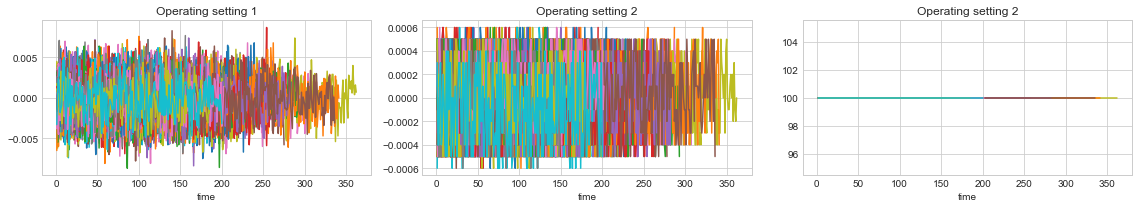

In [464]:
plot_op_setting(train_fd1)

Each color above represents a engine unit.  
It is clear that the operating settings vary much, but for the first operating settings it seems that the range shrinks over time.

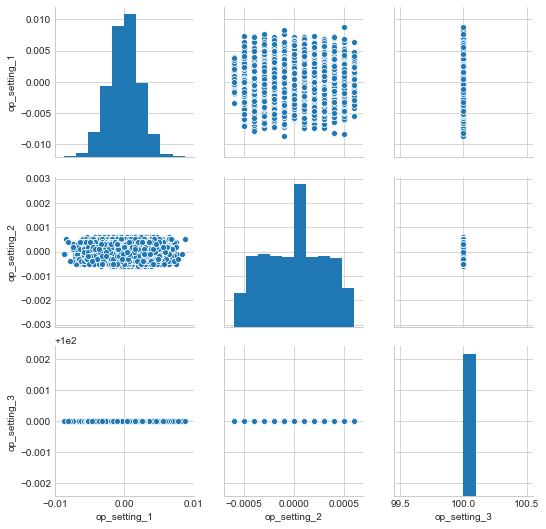

In [465]:
sns.pairplot(data=train_fd1, vars=op_settings)

No clear relationship between operatin settings

It is clear that some sensor are constant and others don't show any pattern over time (e.g. sensor 14), but others reveals some trend (upper or down) over time.

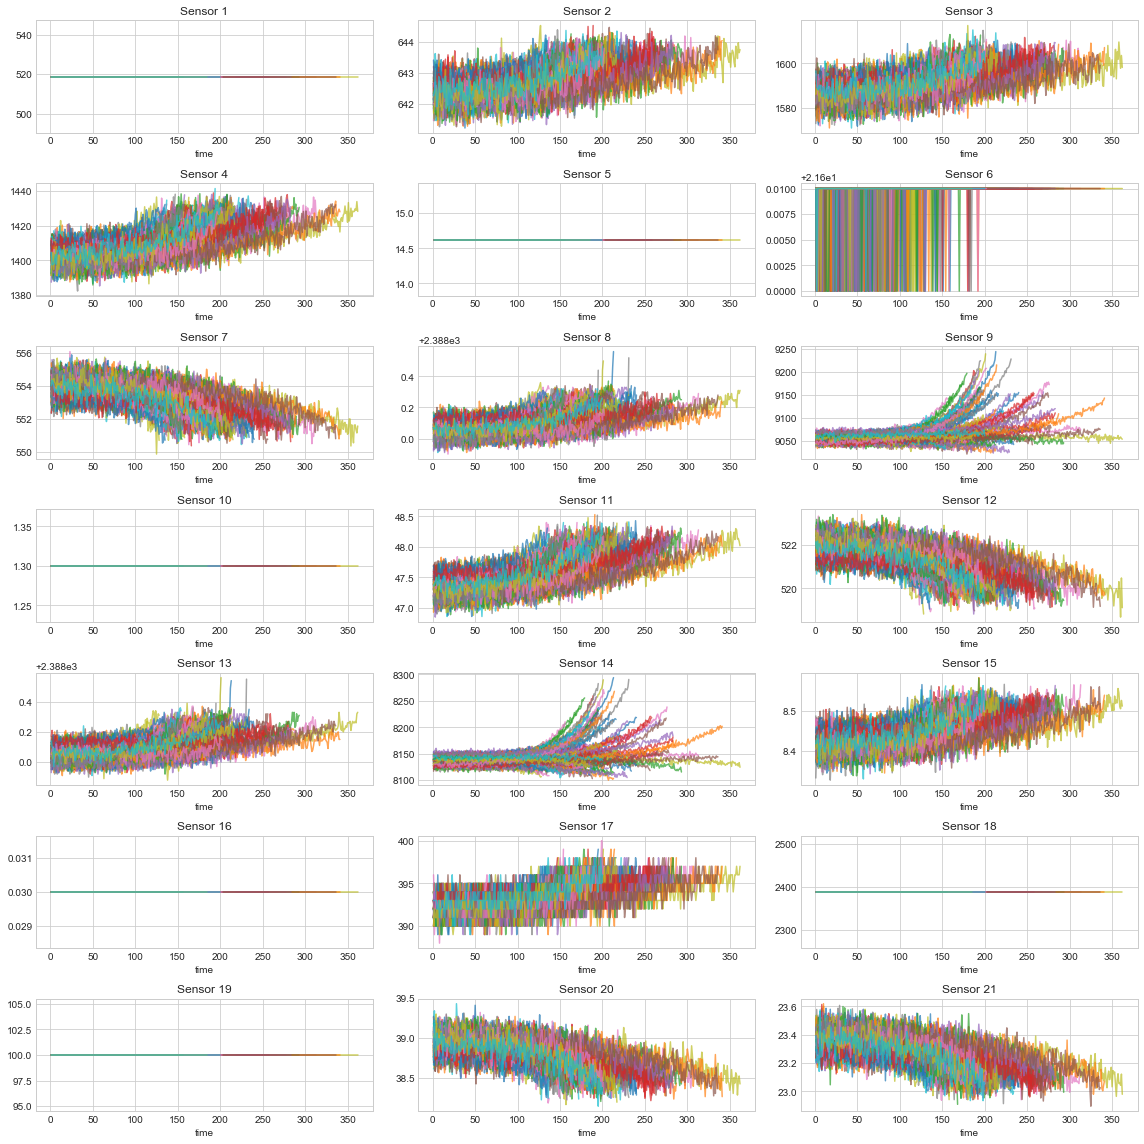

In [466]:
plot_sensor(train_fd1)

### **Train FD2**

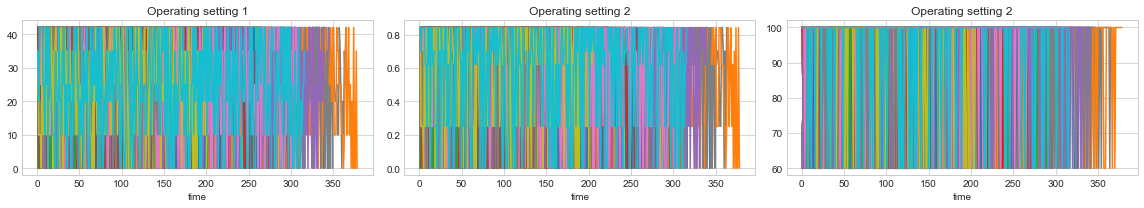

In [467]:
plot_op_setting(train_fd2)

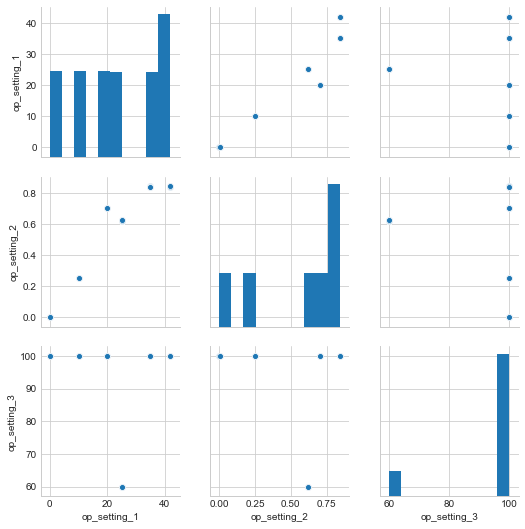

In [468]:
sns.pairplot(train_fd2, vars=op_settings)

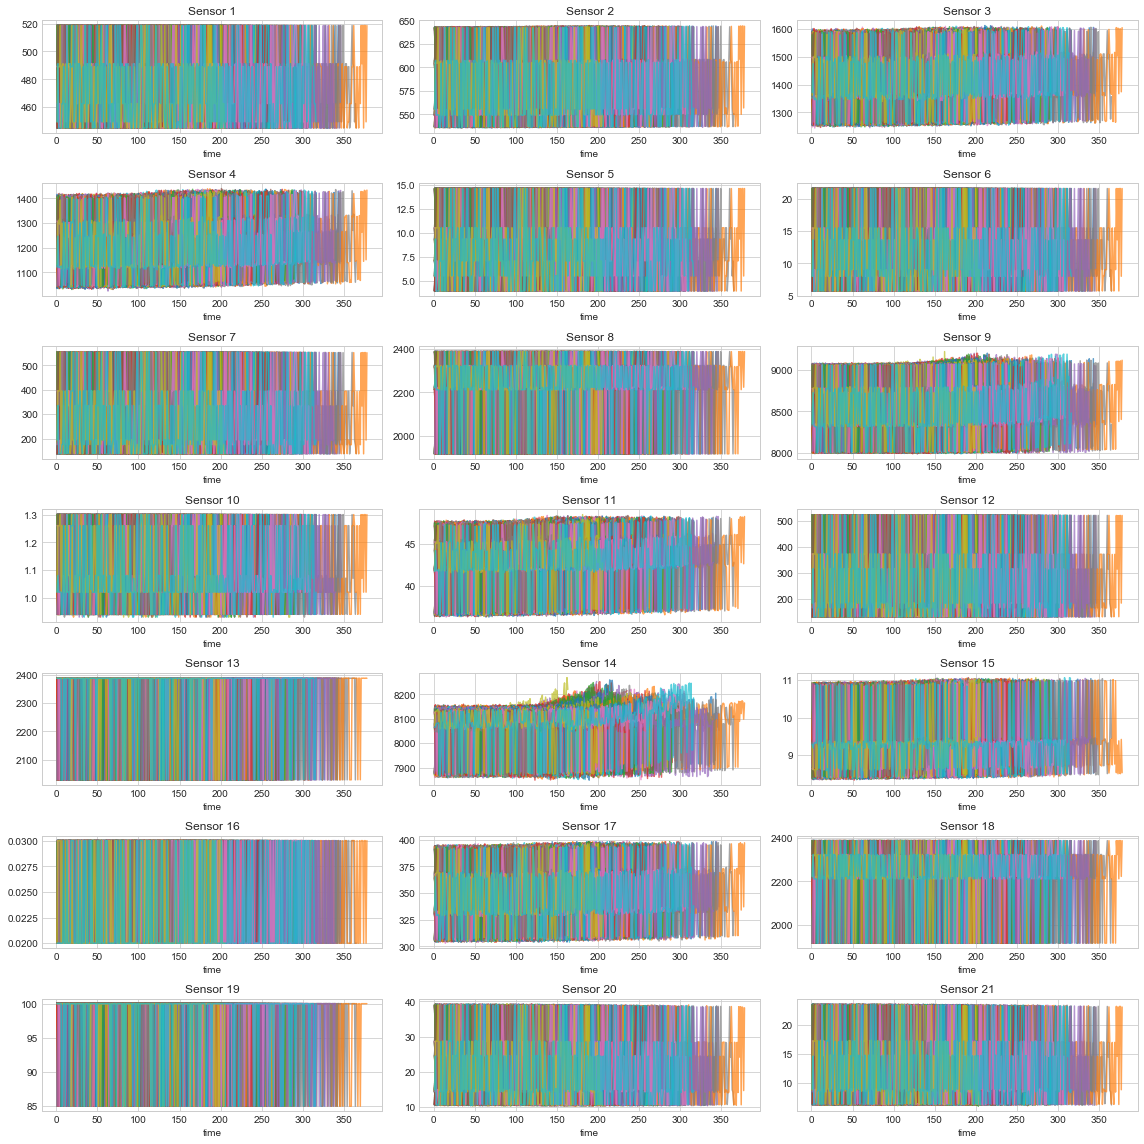

In [469]:
plot_sensor(train_fd2)

Here, only sensor 14 seems to reveal some pattern over time

### **Train FD3**

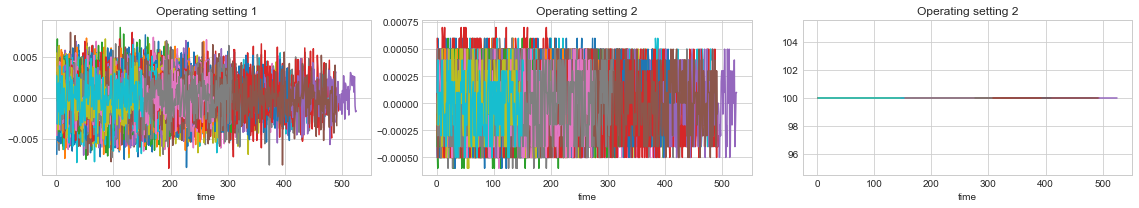

In [470]:
plot_op_setting(train_fd3)

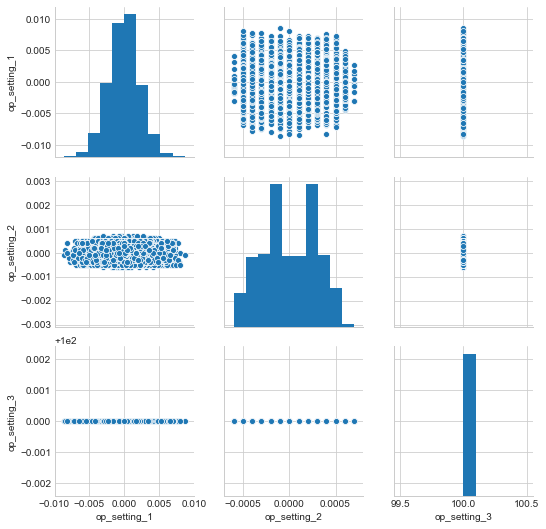

In [471]:
sns.pairplot(train_fd3, vars=op_settings)

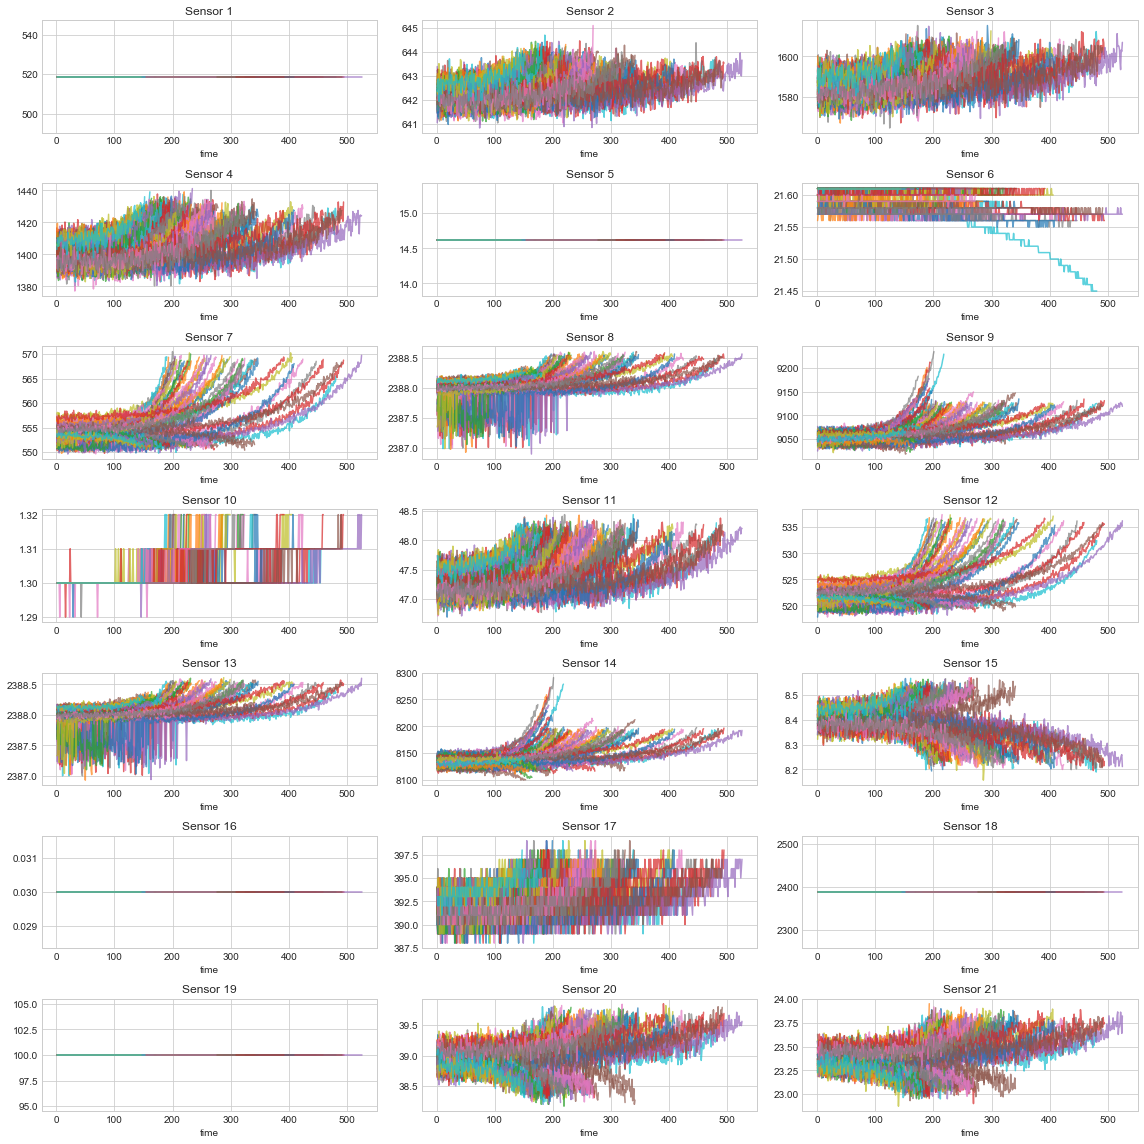

In [472]:
plot_sensor(train_fd3)

Some patterns are different than FD1, perhaps because we have now two fault modes

### **Train FD4**

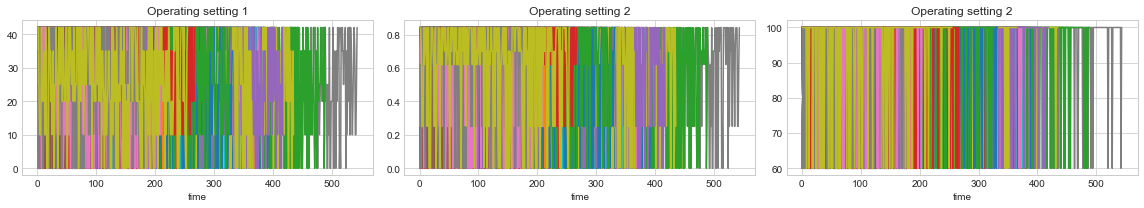

In [473]:
plot_op_setting(train_fd4)

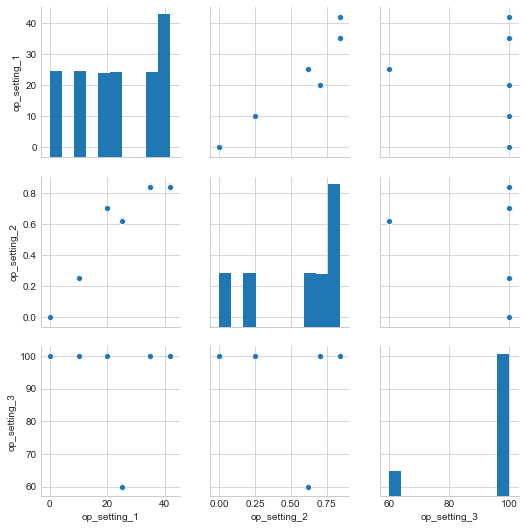

In [593]:
sns.pairplot(train_fd4, vars=op_settings)
plt.savefig('../output/plots/eda_operational_raw.png')

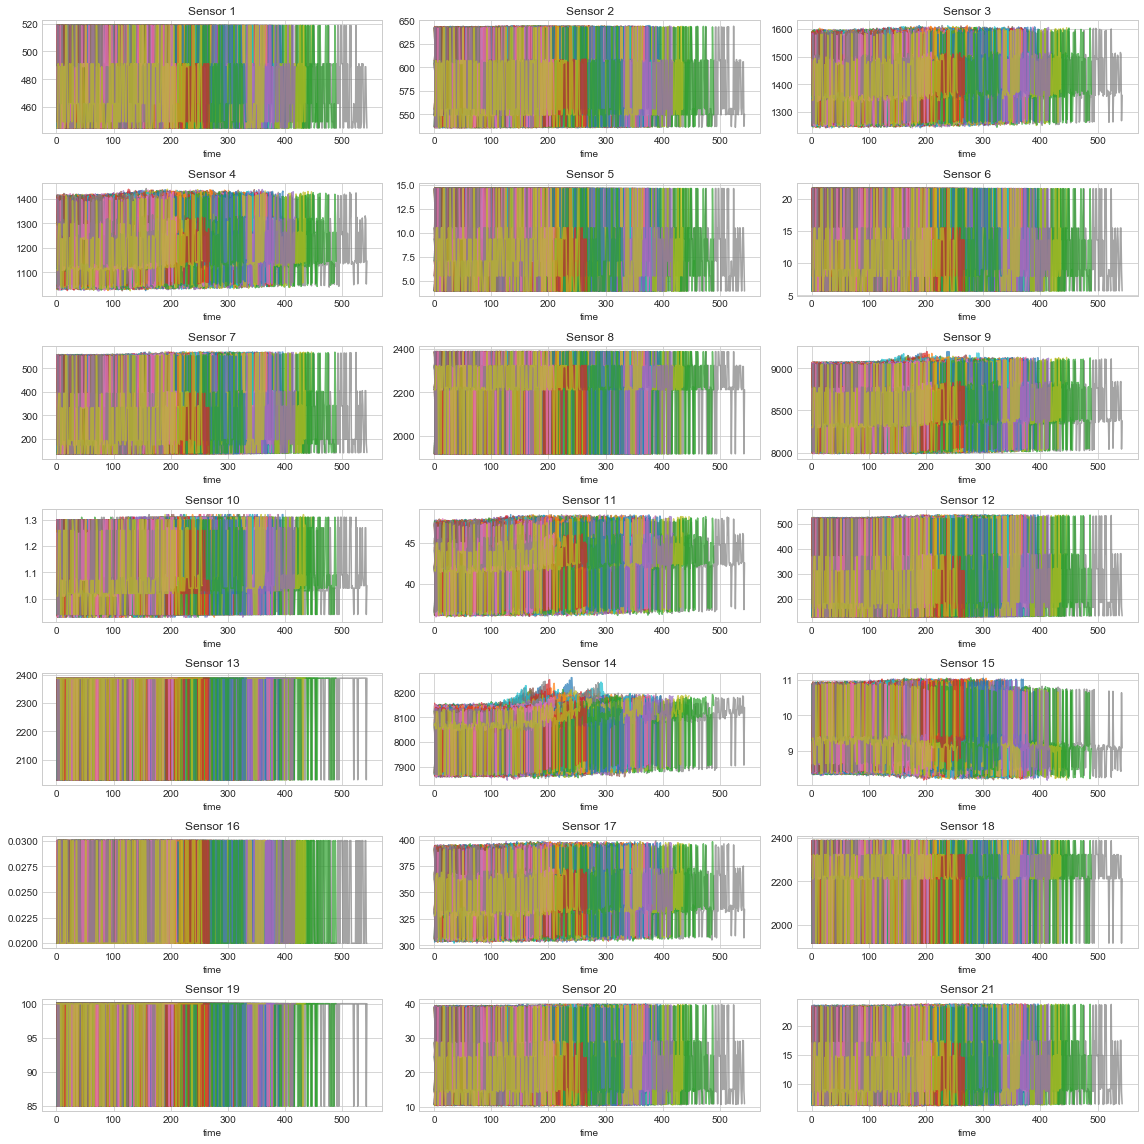

In [587]:
plot_sensor(train_fd4)

plt.savefig('../output/plots/eda_sensors_raw.png')

Again, very unclear patterns and messy data

---

## **RUL vs variables**

In [592]:
len(test['unit_number'].unique())

248

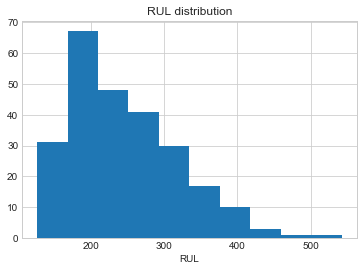

In [586]:
plt.hist(train_fd4.groupby(by='unit_number').max()['rul'])
plt.title('RUL distribution')
plt.xlabel('RUL');

plt.savefig('../output/plots/eda_rul_distribution.png')

In [477]:
train_fd4.groupby(by='unit_number').max()['rul'].describe()

count    249.00000
mean     244.97992
std       73.11080
min      127.00000
25%      189.00000
50%      233.00000
75%      289.00000
max      542.00000
Name: rul, dtype: float64

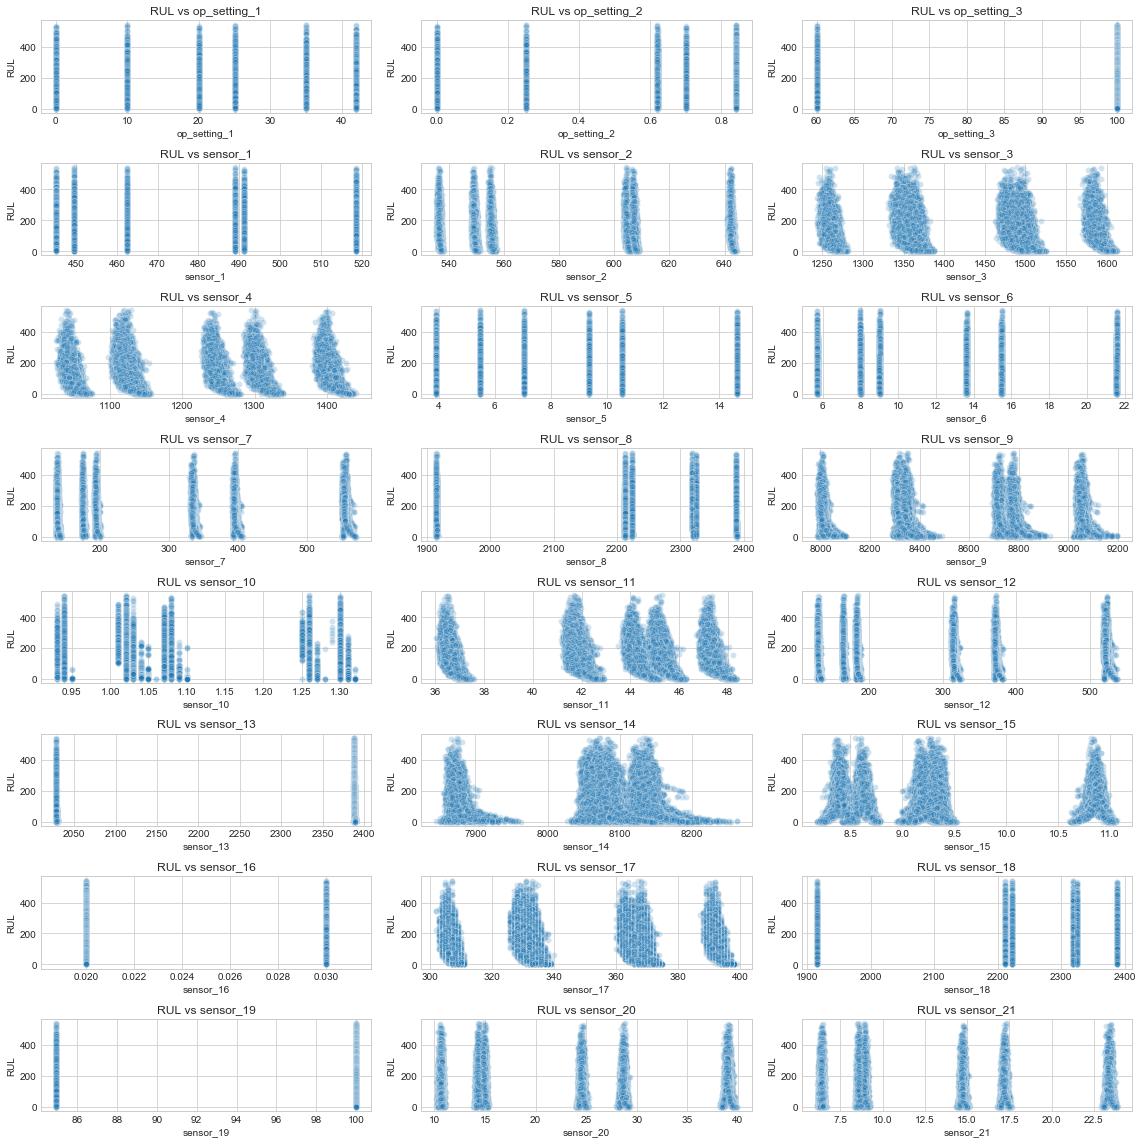

In [584]:
fig = plt.figure(figsize=(16, 16))

for i in range(train_fd4[op_settings + sensors].shape[1]):
    ax = fig.add_subplot(8, 3, i+1)
    var = train_fd1.columns[2+i]
    sns.scatterplot(x=train_fd4.loc[:, var], y=train_fd4['rul'], ax=ax, alpha=0.2)
    ax.set_xlabel(var)
    ax.set_ylabel('RUL')
    ax.set_title('RUL vs {}'.format(var))
        
fig.tight_layout()

plt.savefig('../output/plots/eda_scatters_raw.png')

We can see clear separations of sensors' operating regions. There must be some correlation with the six operating modes.  
Let's try to cluster such modes

## **Unsupervised clustering**

In [479]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [480]:
kmean = KMeans(n_clusters=6)

#scaler = StandardScaler()
kmean.fit(train_fd4[op_settings + sensors])
train_fd4['cluster'] = kmean.predict(train_fd4[op_settings + sensors])
test_fd4['cluster'] = kmean.predict(test_fd4[op_settings + sensors])

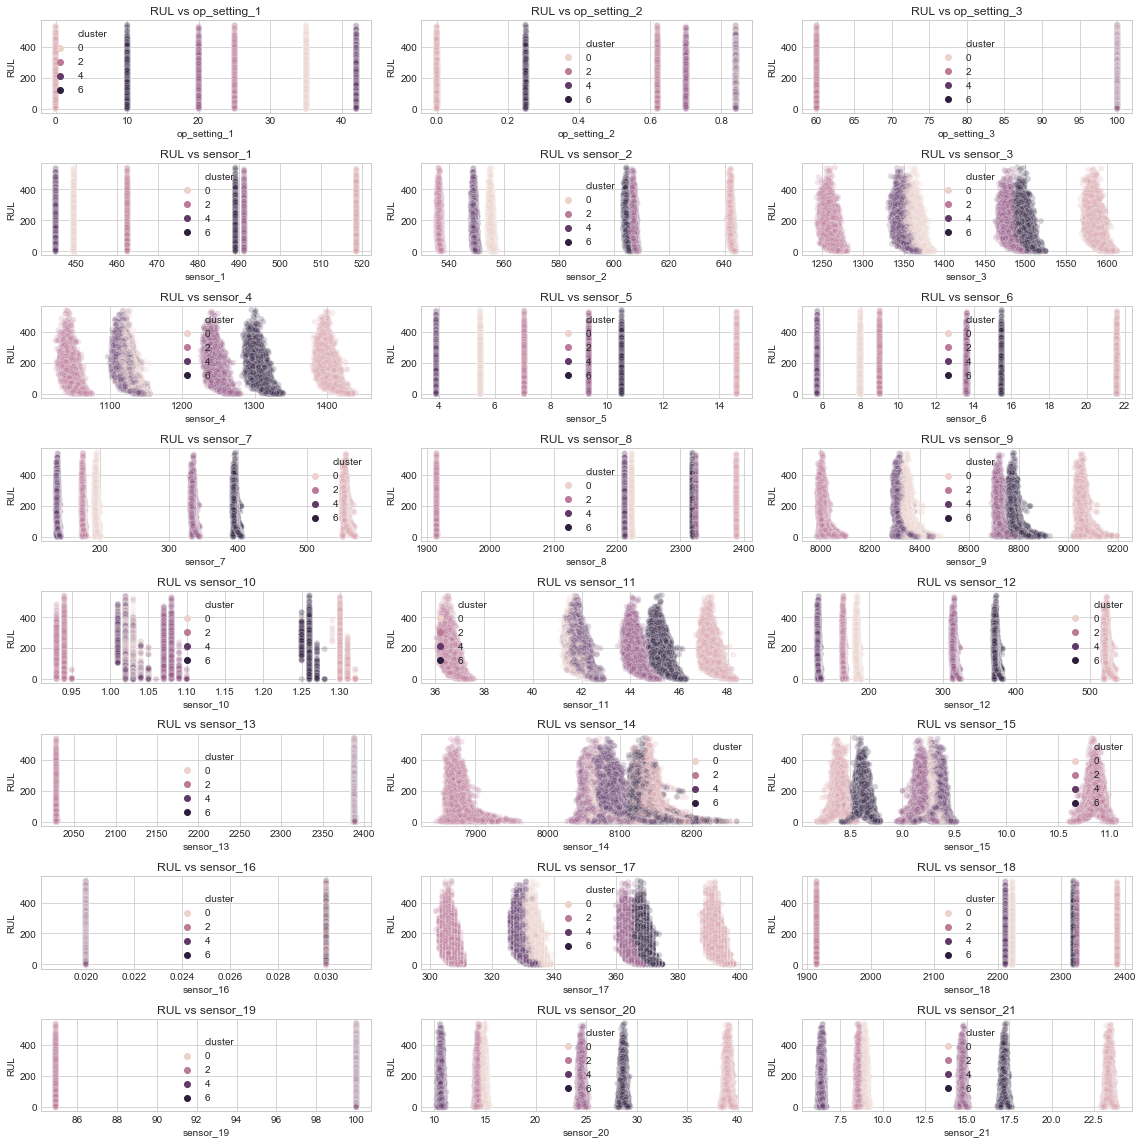

In [583]:
fig = plt.figure(figsize=(16, 16))

for i in range(train_fd4[op_settings + sensors].shape[1]):
    ax = fig.add_subplot(8, 3, i+1)
    var = train_fd1.columns[2+i]
    sns.scatterplot(x=train_fd4.loc[:, var], y=train_fd4['rul'], ax=ax, alpha=0.2, hue=train_fd4.cluster)
    ax.set_xlabel(var)
    ax.set_ylabel('RUL')
    ax.set_title('RUL vs {}'.format(var))
        
fig.tight_layout()

plt.savefig('../output/plots/eda_scatters_cluster.png')

The noisy data, therefore, arises from changes in operating modes, which produces the intermitent switching levels of sensors measurements.  
We should, therefore, scale the data by operating mode to get a more smooth and continuous trend.

In [482]:
scaler_0 = StandardScaler()
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_3 = StandardScaler()
scaler_4 = StandardScaler()
scaler_5 = StandardScaler()

scaler_dict = {
    0: scaler_0,
    1: scaler_1,
    2: scaler_2,
    3: scaler_3,
    4: scaler_4,
    5: scaler_5,
}

**Train**

In [483]:
train_fd4_scaled = train_fd4.copy(deep=True)

for cluster in np.unique(kmean.labels_):
    mask = train_fd4['cluster'] == cluster
    mask_scaled = train_fd4_scaled['cluster'] == cluster
    scaler = scaler_dict[cluster]
    train_fd4_scaled.loc[mask_scaled, sensors] = scaler.fit_transform(train_fd4.loc[mask, sensors])

Remove constant features within any operating mode

In [484]:
tol = 1e-06
keep_var = np.ones(len(sensors))

for cluster in np.unique(kmean.labels_):
    scaler = scaler_dict[cluster]
    for i in range(len(sensors)):
        if scaler.var_[i] < tol:
            keep_var[i] = 0

In [485]:
sensors_keep = [s for s, k in zip(sensors, keep_var) if k == 1]
sensors_drop = [s for s, k in zip(sensors, keep_var) if k == 0]

print('Sensors Dropped {}'.format(sensors_drop))

Sensors Dropped ['sensor_1', 'sensor_5', 'sensor_16', 'sensor_18', 'sensor_19']


In [486]:
train_fd4_scaled.drop(sensors_drop, axis=1, inplace=True)

**Test**

In [487]:
test_fd4_scaled = test_fd4.copy(deep=True)

for cluster in np.unique(kmean.labels_):
    mask = test_fd4['cluster'] == cluster
    mask_scaled = test_fd4_scaled['cluster'] == cluster
    scaler = scaler_dict[cluster]
    test_fd4_scaled.loc[mask_scaled, sensors] = scaler.transform(test_fd4.loc[mask, sensors])

In [488]:
test_fd4_scaled.drop(sensors_drop, axis=1, inplace=True)

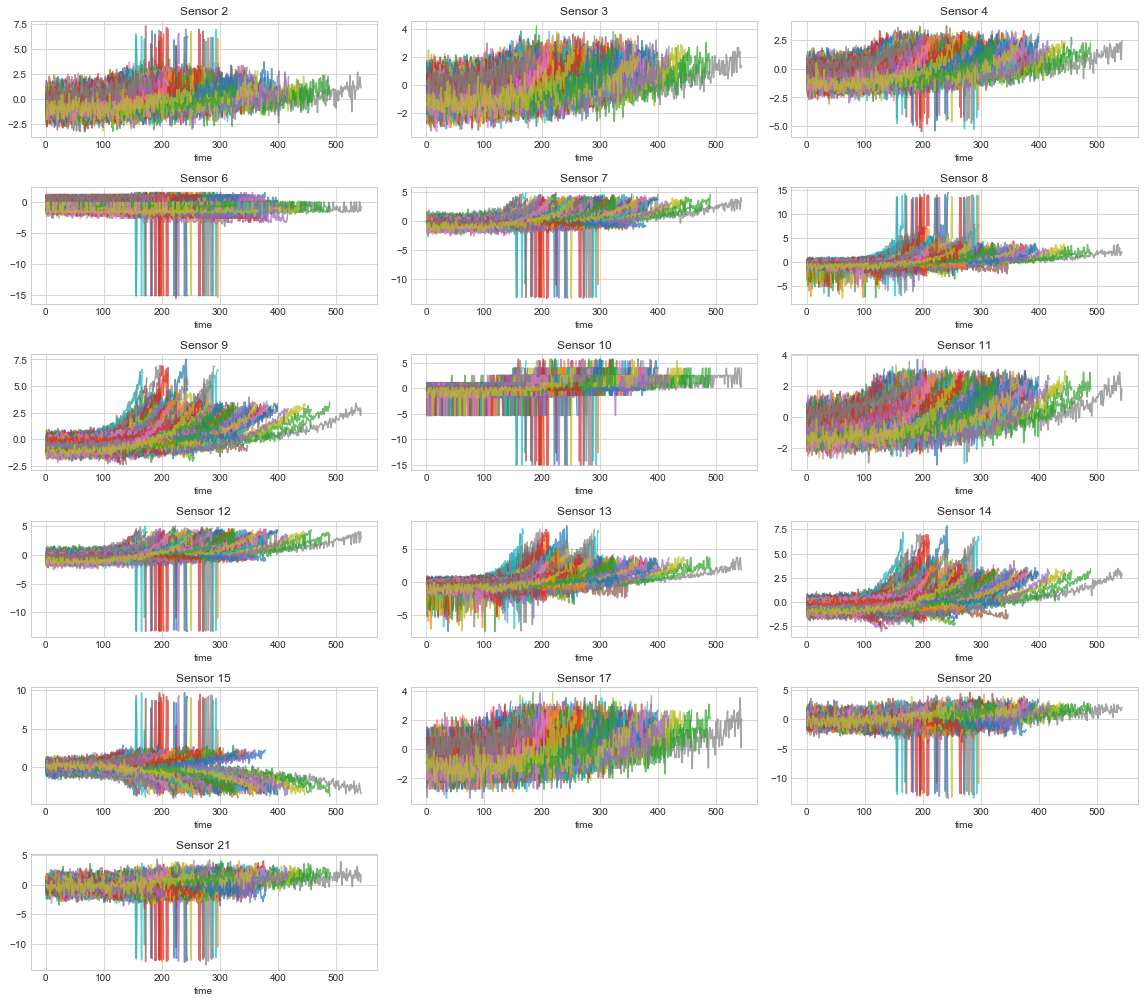

In [581]:
fig = plt.figure(figsize=(16, 16))


for i in range(len(sensors_keep)):   
    ax = fig.add_subplot(7, 3, i + 1)
    sensor = train_fd4_scaled[sensors_keep].columns[i]
    sensor_name = sensor.replace('_', ' ').capitalize()

    ax.plot(train_fd4_scaled.pivot('time', 'unit_number', sensor), alpha=0.7)
    ax.set_xlabel('time')
    ax.set_title(sensor_name);

fig.tight_layout()

plt.savefig('../output/plots/eda_sensors_std.png')

The plot is much clearer and less noisy

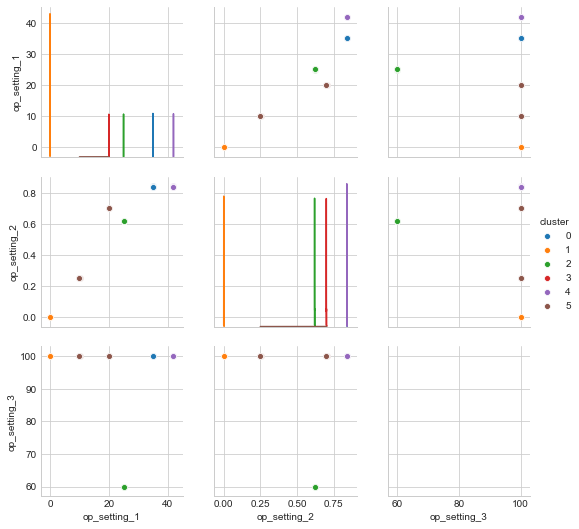

In [580]:
sns.pairplot(train_fd4, vars=op_settings, hue='cluster')
plt.savefig('../output/plots/eda_operational_cluster.png')

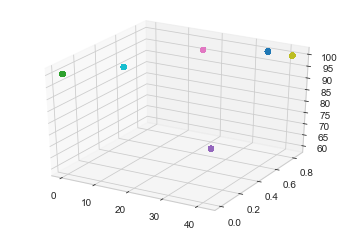

In [491]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    train_fd4_scaled['op_setting_1'], 
    train_fd4_scaled['op_setting_2'], 
    train_fd4_scaled['op_setting_3'], 
    zdir='z', 
    s=20, 
    c=train_fd4_scaled['cluster'], 
    depthshade=True,
    cmap='tab10');


As suspected, each histogram is a separate cluster that indicate one separate operating mode

** OneHot encoding for cluster variable **

In [492]:
from sklearn.preprocessing import OneHotEncoder

In [493]:
enc = OneHotEncoder(sparse=False)

In [494]:
enc.fit(train_fd4['cluster'].values.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [495]:
one_hot_cluster_train = pd.DataFrame(columns=['cluster_' + str(i) for i in range(6)],
                               data=enc.transform(train_fd4['cluster'].values.reshape(-1, 1)))

one_hot_cluster_test = pd.DataFrame(columns=['cluster_' + str(i) for i in range(6)],
                               data=enc.transform(test_fd4['cluster'].values.reshape(-1, 1)))

In [496]:
train_fd4_scaled = train_fd4_scaled.join(one_hot_cluster_train)
train_fd4_scaled.drop(['cluster'], axis=1, inplace=True)

test_fd4_scaled = test_fd4_scaled.join(one_hot_cluster_test)
test_fd4_scaled.drop(['cluster'], axis=1, inplace=True)

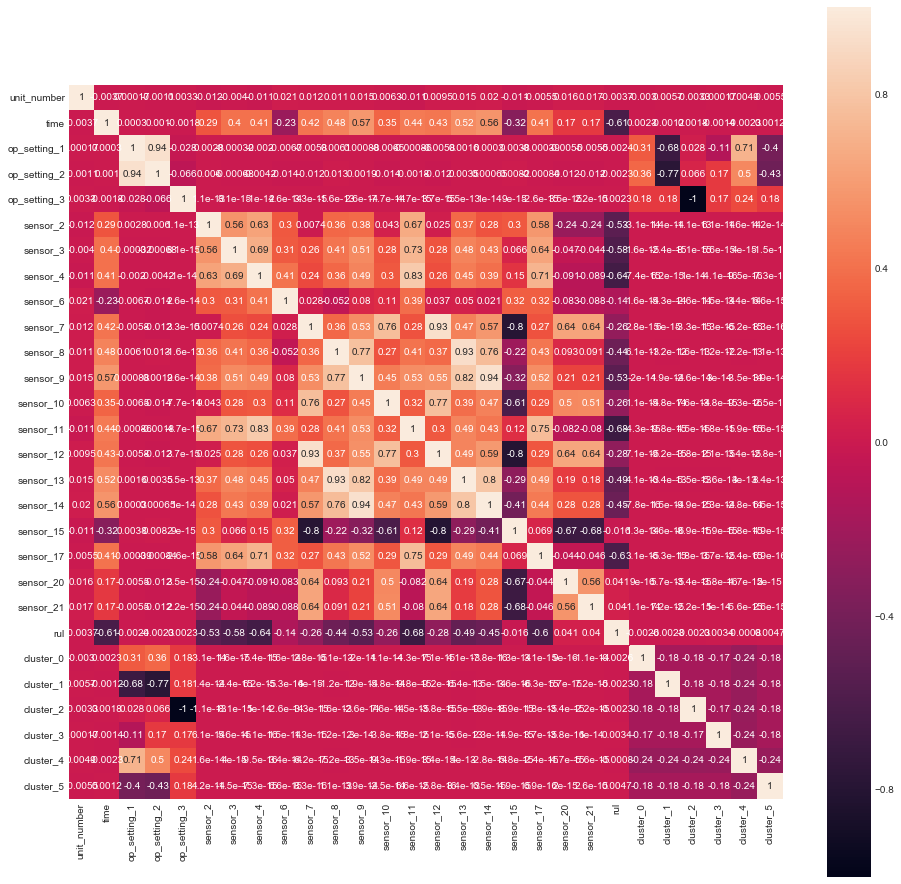

In [497]:
plt.figure(figsize=(16, 16))
sns.heatmap(train_fd4_scaled.corr(), annot=True, square=True)

### **Feature Engineering**

Let's have a cumulative counting of operating modes per unit

In [498]:
train_fd4_scaled.columns

Index(['unit_number', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8',
       'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'rul',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5'],
      dtype='object')

In [499]:
test_fd4_scaled.columns

Index(['unit_number', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8',
       'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'rul',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5'],
      dtype='object')

**Train**

In [500]:
for op in np.unique(kmean.labels_):
    var = 'count_op_' + str(op)
    cluster_var = 'cluster_' + str(op)
    train_fd4_scaled[var] = np.nan
    for u in train_fd4['unit_number'].unique():
        mask = (train_fd4_scaled['unit_number'] == u) # & (train_fd4_scaled['cluster'] == op)
        train_fd4_scaled.loc[mask, var] = train_fd4_scaled.loc[mask, cluster_var].cumsum()

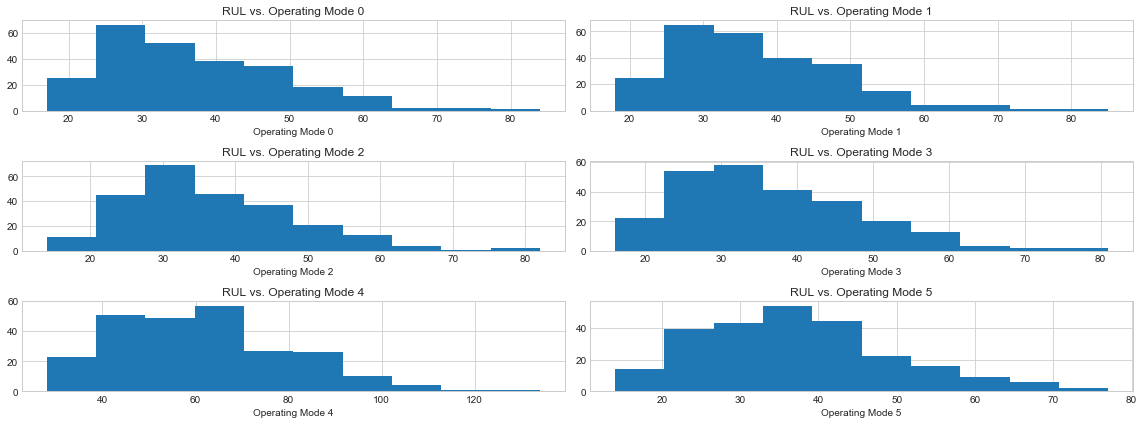

In [501]:
fig = plt.figure(figsize=(16, 6))

df = train_fd4_scaled.groupby(by=['unit_number']).max()
for op in np.unique(kmean.labels_):
    ax = fig.add_subplot(3, 2, op+1)
    ax.hist(df['count_op_' + str(op)])
    ax.set_title('RUL vs. Operating Mode {}'.format(op))
    ax.set_xlabel('Operating Mode {}'.format(op))
    #ax.set_ylabel('RUL')
    
fig.tight_layout()

In [502]:
df[[c for c in df.columns if 'count_op' in c]].describe()

count_op_0  count_op_1  count_op_2  count_op_3  count_op_4  count_op_5
count  249.000000  249.000000  249.000000  249.000000  249.000000  249.000000
mean    36.795181   37.100402   36.702811   36.349398   61.827309   37.204819
std     11.705829   11.317359   11.723633   11.692395   18.601463   12.525869
min     17.000000   18.000000   14.000000   16.000000   28.000000   14.000000
25%     27.000000   28.000000   29.000000   27.000000   48.000000   28.000000
50%     35.000000   35.000000   34.000000   34.000000   60.000000   37.000000
75%     44.000000   44.000000   44.000000   44.000000   73.000000   44.000000
max     84.000000   85.000000   82.000000   81.000000  134.000000   77.000000

Operating Mode 0 is the most used

**Test**

In [503]:
for op in np.unique(kmean.labels_):
    var = 'count_op_' + str(op)
    cluster_var = 'cluster_' + str(op)
    test_fd4_scaled[var] = np.nan
    for u in test_fd4['unit_number'].unique():
        mask = (test_fd4_scaled['unit_number'] == u) # & (train_fd4_scaled['cluster'] == op)
        test_fd4_scaled.loc[mask, var] = test_fd4_scaled.loc[mask, cluster_var].cumsum()

### Export processed files

In [504]:
train_fd4_scaled.to_csv('../input/processed/train_fd4_processed.csv', index=False)
test_fd4_scaled.to_csv('../input/processed/test_fd4_processed.csv', index=False)

## **Modeling**

In [505]:
train = pd.read_csv('../input/processed/train_fd4_processed.csv')
test = pd.read_csv('../input/processed/test_fd4_processed.csv')

In [548]:
features = sensors_keep + \
    [c for c in train.columns if 'cluster_' in c] + \
    [c for c in train.columns if 'count_op' in c]
    
target_var = 'rul'

X_train = train[features]
y_train = train[target_var]

X_test = test[features]
y_test = test[target_var]

We will cross validate our models into 5 folds, each fold is a holdout of approximately 20% of units

In [507]:
from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score

In [508]:
gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

### Regression

In [509]:
pipe_reg_linear = Pipeline([
    ('model', LinearRegression())
])

pipe_reg_rf = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipe_reg_gb = Pipeline([
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

pipes_reg = [pipe_reg_linear, pipe_reg_rf, pipe_reg_gb]
models_reg_dict = {
    0: 'Linear Regression',
    1: 'Random Forest',
    2: 'Gradient Boosting'}

In [510]:
import warnings
warnings.filterwarnings('ignore')

In [511]:
print('Performing model optimizations...')
best_score_reg = float('inf')
best_model_reg = 0
best_pipe_reg = ''
score_reg = []


for i, p in enumerate(pipes_reg):
    print('======== {} ========'.format(models_reg_dict[i]))
    
    # Fit models
    score_reg.append(
        np.mean(
            cross_val_score(
                p, X_train, y_train, 
                cv=gss.split(X_train, y_train, groups=train['unit_number']), 
                scoring=make_scorer(mean_squared_error, greater_is_better=False)
            )
        )
    )
    
    print('CV Mean MSE Score: {}'.format(score_reg[i]))
    
    print()

Performing model optimizations...
======== Linear Regression ========
CV Mean MSE Score: -3318.966418196177

======== Random Forest ========
CV Mean MSE Score: -2900.3956306987484

======== Gradient Boosting ========
CV Mean MSE Score: -2744.7353836251814



Best model is Gradient Boosting. Let's try to tune it a bit finer, with Grid Search

In [512]:
best_score_reg = float('-inf')

for i in range(len(score)):
    if score_reg[i] > best_score_reg:
        best_score_reg = score_reg[i]
        best_pipe_reg = pipes_reg[i]

In [513]:
learning_rate = [0.03, 0.1, 0.3]
depths = [3, 5, 10]
n_estimators = [50, 100, 300]

grid_params_gb = [{
    'model__n_estimators': n_estimators,
    'model__max_depth': depths,
    'model__learning_rate': learning_rate}]

gs_gb = GridSearchCV(
    estimator=best_pipe_reg,
    param_grid=grid_params_gb,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=gss.split(X_train, y_train, groups=train['unit_number']), 
    n_jobs=-1)

In [514]:
gs_gb.fit(X_train, y_train)

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x00000218A5C30E60>,
       error_score='raise',
       estimator=Pipeline(steps=[('model', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'model__n_estimators': [50, 100, 300], 'model__max_depth': [3, 5, 10], 'model__learning_rate': [0.03, 0.1, 0.3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [515]:
gs_gb.best_params_

{'model__learning_rate': 0.03,
 'model__max_depth': 5,
 'model__n_estimators': 100}

In [516]:
gs_gb.grid_scores_

[mean: -3194.15044, std: 805.50657, params: {'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 50},
 mean: -2811.28137, std: 727.56037, params: {'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 100},
 mean: -2757.26026, std: 697.53601, params: {'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 300},
 mean: -2984.24200, std: 767.61845, params: {'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__n_estimators': 50},
 mean: -2714.60142, std: 695.92836, params: {'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__n_estimators': 100},
 mean: -2739.57221, std: 653.92423, params: {'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__n_estimators': 300},
 mean: -3005.87859, std: 740.88775, params: {'model__learning_rate': 0.03, 'model__max_depth': 10, 'model__n_estimators': 50},
 mean: -2867.38232, std: 661.14848, params: {'model__learning_rate': 0.03, 'model__max_depth': 10, 'model__n_esti

In [517]:
reg = gs_gb.best_estimator_

In [567]:
train['pred'] = reg.predict(X_train)

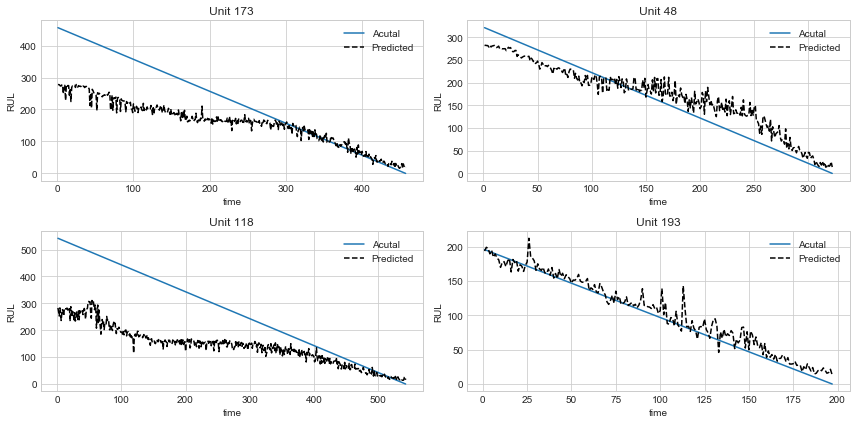

In [519]:
fig = plt.figure(figsize=(12, 6))

np.random.seed(0)
units = np.random.choice(train['unit_number'].unique(), size=4)

for i, u in enumerate(units):
    ax = fig.add_subplot(2, 2, i+1)
    df = train.loc[train['unit_number'] == u]
    ax.plot(df['time'], df['rul'], label='Acutal')
    ax.plot(df['time'], df['pred'], label='Predicted', linestyle='dashed', color='black')
    ax.set_title('Unit {}'.format(u))
    ax.set_ylabel('RUL')
    ax.set_xlabel('time')
    ax.legend()

fig.tight_layout()

It is interesting to notice that for the sample shown, the predictions get closer to actual values near the end of RUL. For some units, such as 118 and 183, the predictions are understimated for most of the times.

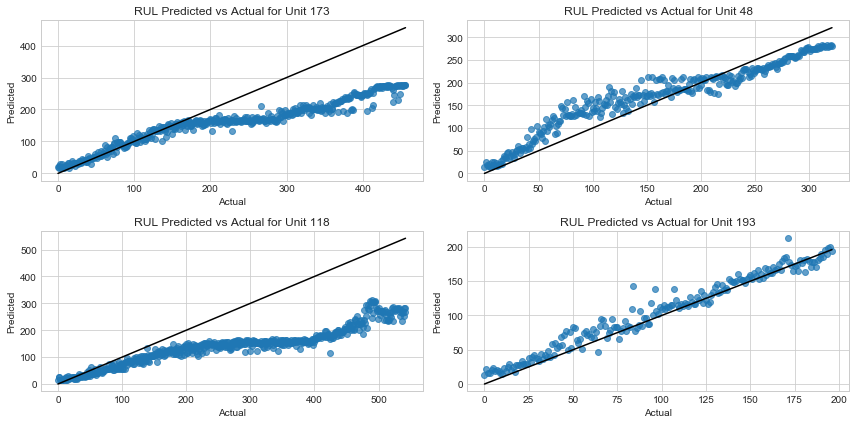

In [520]:
fig = plt.figure(figsize=(12, 6))

np.random.seed(0)
units = np.random.choice(train['unit_number'].unique(), size=4)

for i, u in enumerate(units):
    ax = fig.add_subplot(2, 2, i+1)
    df = train.loc[train['unit_number'] == u]
    ax.scatter(df['rul'], df['pred'], alpha=0.7)
    ax.plot(df['rul'], df['rul'], color='black')
    ax.set_title('RUL Predicted vs Actual for Unit {}'.format(u))
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Actual')

fig.tight_layout()

** Residuals **

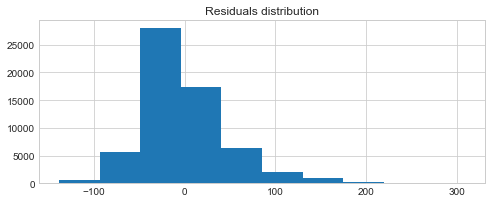

In [521]:
train['residuals'] = train['rul'] - train['pred']

plt.figure(figsize=(8, 3))
plt.hist(train['residuals'])
plt.title('Residuals distribution')

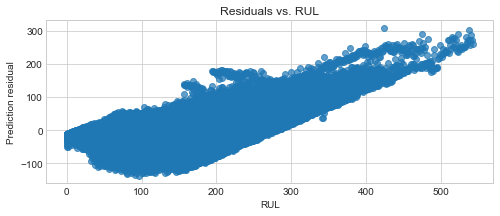

In [522]:
plt.figure(figsize=(8, 3))

plt.scatter(train['rul'], train['residuals'], alpha=0.7)
plt.title('Residuals vs. RUL')
plt.xlabel('RUL')
plt.ylabel('Prediction residual');

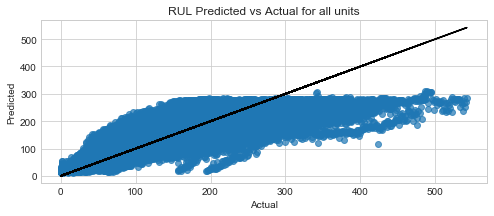

In [579]:
plt.figure(figsize=(8, 3))

plt.scatter(train['rul'], train['pred'], alpha=0.7)
plt.plot(train['rul'], train['rul'], color='black')
plt.title('RUL Predicted vs Actual for all units')
plt.ylabel('Predicted')
plt.xlabel('Actual');

plt.savefig('../output/plots/reg_rul_pred_true.png')

#### Post-processing - Kalman Filter

In [524]:
gs_gb.best_score_

-2714.6014206026352

In [525]:
# our RUL always decrease by 1 after a cycle
# so our state is [RUL, -1]
# transition matrix = [[1, 1], [0, 1]]
n_dim_state= 2
n_dim_obs= 1
a_transition_matrix = np.array(
    [[1, 1], 
     [0, 1]])
r_observation_covariance = np.diag([-gs_gb.best_score_])
h_observation_matrices = np.array([[1, 0]])

In [526]:
import pykalman as pyk

train['pred_filtered'] = np.nan

for unit in train['unit_number'].unique():
    preds_for_unit = train.loc[train['unit_number'] == unit, 'pred']
    observations = preds_for_unit.values
    initial_state_mean = np.array([observations[0], -1])
    kf = pyk.KalmanFilter(transition_matrices=a_transition_matrix,
                          initial_state_mean=initial_state_mean,
                          observation_covariance=r_observation_covariance,
                          observation_matrices=h_observation_matrices,
                          n_dim_state=n_dim_state, 
                          n_dim_obs=n_dim_obs)
    mean, _ = kf.filter(observations)
    train.loc[train['unit_number'] == unit, 'pred_filtered'] = mean[:, 0]

In [527]:
score_filtered = -mean_squared_error(y_train, train['pred_filtered'])
print('score filtered: {} vs. non-filtered: {}'.format(score_filtered, gs_gb.best_score_))

score filtered: -2162.7662252493815 vs. non-filtered: -2714.6014206026352


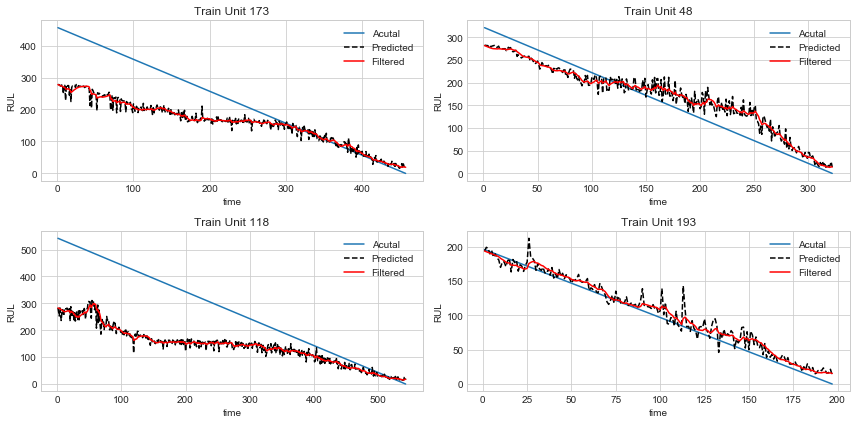

In [569]:
fig = plt.figure(figsize=(12, 6))

np.random.seed(0)
units = np.random.choice(train['unit_number'].unique(), size=4)

for i, u in enumerate(units):
    ax = fig.add_subplot(2, 2, i+1)
    df = train.loc[train['unit_number'] == u]
    ax.plot(df['time'], df['rul'], label='Acutal')
    ax.plot(df['time'], df['pred'], label='Predicted', linestyle='dashed', color='black')
    ax.plot(df['time'], df['pred_filtered'], label='Filtered', color='red')
    ax.set_title('Train Unit {}'.format(u))
    ax.set_ylabel('RUL')
    ax.set_xlabel('time')
    ax.legend()

fig.tight_layout()

plt.savefig('../output/plots/reg_train_units_pred.png')

### Test Score

In [570]:
test['pred'] = reg.predict(X_test)
test_score = -mean_squared_error(y_test, test['pred'])

In [572]:
test['pred_filtered'] = np.nan

for unit in test['unit_number'].unique():
    preds_for_unit = test.loc[test['unit_number'] == unit, 'pred']
    observations = preds_for_unit.values
    initial_state_mean = np.array([observations[0], -1])
    kf = pyk.KalmanFilter(transition_matrices=a_transition_matrix,
                          initial_state_mean=initial_state_mean,
                          observation_covariance=r_observation_covariance,
                          observation_matrices=h_observation_matrices,
                          n_dim_state=n_dim_state, 
                          n_dim_obs=n_dim_obs)
    mean, _ = kf.filter(observations)
    test.loc[test['unit_number'] == unit, 'pred_filtered'] = mean[:, 0]

In [573]:
test_score_filtered = -mean_squared_error(y_test, test['pred_filtered'])
print('score filtered: {} vs. non-filtered: {}'.format(test_score_filtered, test_score))

score filtered: -4699.351173589053 vs. non-filtered: -4781.517662311785


**Linear Reg benchmark**

In [574]:
pipe_reg_linear.fit(X_train, y_train)
ypred_lr = pipe_reg_linear.predict(X_test)

score_lr = -mean_squared_error(y_test, ypred_lr)
score_lr

-5467.759957340871

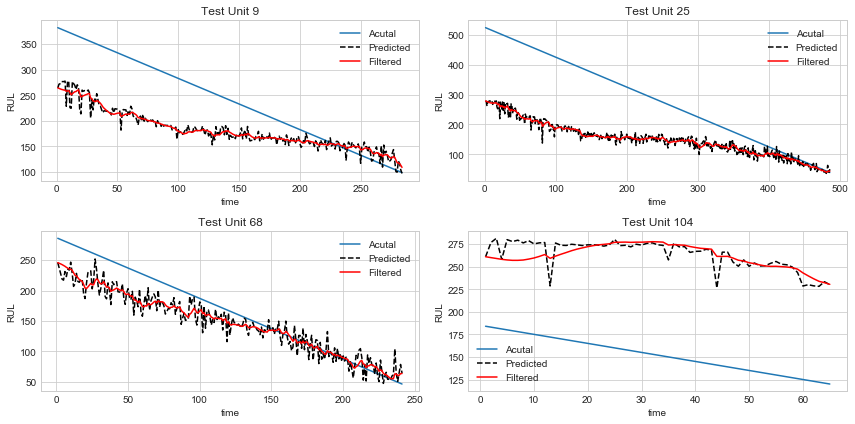

In [578]:
fig = plt.figure(figsize=(12, 6))

np.random.seed(100)
units = np.random.choice(test['unit_number'].unique(), size=4)

for i, u in enumerate(units):
    ax = fig.add_subplot(2, 2, i+1)
    df = test.loc[test['unit_number'] == u]
    ax.plot(df['time'], df['rul'], label='Acutal')
    ax.plot(df['time'], df['pred'], label='Predicted', linestyle='dashed', color='black')
    ax.plot(df['time'], df['pred_filtered'], label='Filtered', color='red')
    ax.set_title('Test Unit {}'.format(u))
    ax.set_ylabel('RUL')
    ax.set_xlabel('time')
    ax.legend()

fig.tight_layout()

plt.savefig('../output/plots/reg_test_units_pred.png')

### Classification

Classify if the RUL is less than a predefined value, e.g. 20

In [534]:
th = 20

X_train = train[features]
y_train = train[target_var].apply(lambda x: 0 if x >= th else 1)

X_test = test[features]
y_test = test[target_var].apply(lambda x: 0 if x >= th else 1)

In [535]:
pipe_clf_logistic = Pipeline([
    ('model', LogisticRegression())
])

pipe_clf_rf = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_clf_gb = Pipeline([
    ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

pipes_clf = [pipe_clf_logistic, pipe_clf_rf, pipe_clf_gb]

models_clf_dict = {
    0: 'Logistic Regression',
    1: 'Random Forest',
    2: 'Gradient Boosting'}

In [536]:
print('Performing model optimizations...')
best_score_clf = float('inf')
best_model_clf = 0
best_pipe_clf = ''
score_clf = []


for i, p in enumerate(pipes_clf):
    print('======== {} ========'.format(models_clf_dict[i]))
    
    # Fit models
    score_clf.append(
        np.mean(
            cross_val_score(
                p, X_train, y_train, 
                cv=gss.split(X_train, y_train, groups=train['unit_number']), 
                scoring=make_scorer(f1_score, greater_is_better=True)
            )
        )
    )
    
    print('CV Mean F1 Score: {}'.format(score_clf[i]))
    
    print()

Performing model optimizations...
======== Logistic Regression ========
CV Mean F1 Score: 0.7996018959180363

======== Random Forest ========
CV Mean F1 Score: 0.8352676184133561

======== Gradient Boosting ========
CV Mean F1 Score: 0.8324311472473763



Best model is Random Forest. Let's try to tune it a bit finer, with Grid Search

In [537]:
best_score_clf = float('-inf')

for i in range(len(score)):
    if score_clf[i] > best_score_clf:
        best_score_clf = score_clf[i]
        best_pipe_clf = pipes_clf[i]

In [538]:
depths = [3, 5, 10]
n_estimators = [50, 100, 300]

grid_params_rf_clf = [{
    'model__n_estimators': n_estimators,
    'model__max_depth': depths}]

gs_rf_clf = GridSearchCV(
    estimator=best_pipe_clf,
    param_grid=grid_params_rf_clf,
    scoring=make_scorer(f1_score, greater_is_better=True),
    cv=gss.split(X_train, y_train, groups=train['unit_number']), 
    n_jobs=-1)

In [539]:
gs_rf_clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x00000218A4859200>,
       error_score='raise',
       estimator=Pipeline(steps=[('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'model__n_estimators': [50, 100, 300], 'model__max_depth': [3, 5, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score), verbose=0)

In [540]:
gs_rf_clf.best_params_

{'model__max_depth': 10, 'model__n_estimators': 100}

In [541]:
gs_rf_clf.grid_scores_

[mean: 0.76579, std: 0.01280, params: {'model__max_depth': 3, 'model__n_estimators': 50},
 mean: 0.76777, std: 0.01213, params: {'model__max_depth': 3, 'model__n_estimators': 100},
 mean: 0.77568, std: 0.00886, params: {'model__max_depth': 3, 'model__n_estimators': 300},
 mean: 0.80663, std: 0.01164, params: {'model__max_depth': 5, 'model__n_estimators': 50},
 mean: 0.80748, std: 0.01252, params: {'model__max_depth': 5, 'model__n_estimators': 100},
 mean: 0.81013, std: 0.01205, params: {'model__max_depth': 5, 'model__n_estimators': 300},
 mean: 0.83051, std: 0.01321, params: {'model__max_depth': 10, 'model__n_estimators': 50},
 mean: 0.83132, std: 0.01185, params: {'model__max_depth': 10, 'model__n_estimators': 100},
 mean: 0.83101, std: 0.01061, params: {'model__max_depth': 10, 'model__n_estimators': 300}]

In [542]:
gs_rf_clf.best_score_

0.8313192385363742

#### Test score

In [543]:
clf = gs_rf_clf.best_estimator_

test['pred_clf'] = clf.predict(X_test)
test_score = f1_score(y_test, test['pred_clf'])
print('test score: {}'.format(test_score))

test score: 0.5214408233276158


In [544]:
from sklearn.metrics import precision_score

In [545]:
logistic_preds = pipe_clf_logistic.fit(X_train, y_train).predict(X_test)
f1_score(y_test, logistic_preds)

0.5508196721311476

## Test RUL distribution

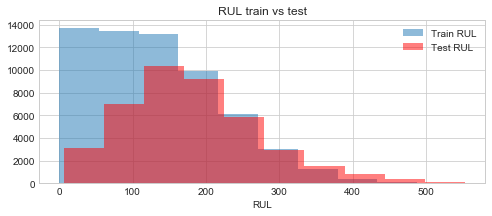

In [565]:
plt.figure(figsize=(8, 3))
plt.hist(train['rul'], alpha=0.5, label='Train RUL')
plt.hist(test['rul'], color='red', alpha=0.5, label='Test RUL')
plt.xlabel('RUL')
plt.legend()
plt.title('RUL train vs test');

plt.savefig('../output/plots/hist_rul_train_test.png')

## Saving models

In [546]:
from sklearn.externals import joblib

In [547]:
# export final df
train.to_csv('../output/data/train_final.csv', index=False)
test.to_csv('../output/data/test_final.csv', index=False)

# export pipes
joblib.dump(pipes_reg, '../output/models/pipe_regression.pkl')
joblib.dump(gs_gb.best_estimator_, '../output/models/grid_search_gradientboosting.pkl')

joblib.dump(pipes_clf, '../output/models/pipe_clf.pkl')
joblib.dump(gs_rf_clf.best_estimator_, '../output/models/grid_search_randomforest_clf.pkl')

['../output/models/grid_search_randomforest_clf.pkl']